# NLP Albumentation with YELP Reviews

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.cluster import KMeansClusterer

c:\Users\echemochek\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Load Data

In [2]:
data = pd.read_csv("data/yelp.csv")
data.head(3)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0


In [4]:
data = data[["text"]]

## Exploration

<AxesSubplot:>

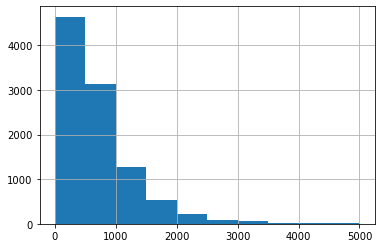

In [5]:
# length of each review
data['text'].str.len().hist()

<AxesSubplot:>

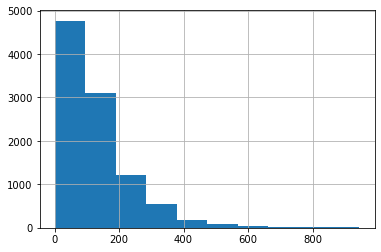

In [6]:
# number of words in each review
data['text'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

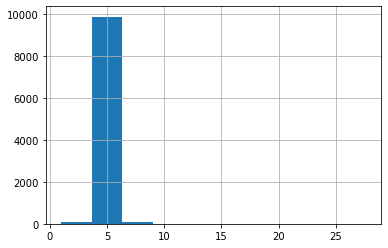

In [8]:
# average word length in each review
data['text'].str.split().apply(lambda x : [len(i) for i in x]). map(lambda x: np.mean(x)).hist()

In [10]:
# distribution of stopwords
stop = set(stopwords.words('english'))

corpus=[]
txt = data['text'].str.split()
txt = txt.values.tolist()
corpus=[word for i in txt for word in i]

from collections import defaultdict
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

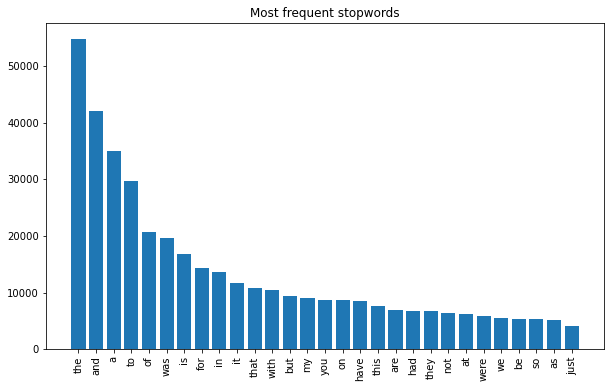

In [11]:
dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))
dic_subset = {key:value for key, value in dic.items() if value > 4000}

names = list(dic_subset.keys())
values = list(dic_subset.values())

plt.figure(figsize=(10,6)) 
plt.bar(range(len(dic_subset)), values, tick_label = names)
plt.title("Most frequent stopwords")
plt.xticks(rotation = 90)
plt.show()

<AxesSubplot:>

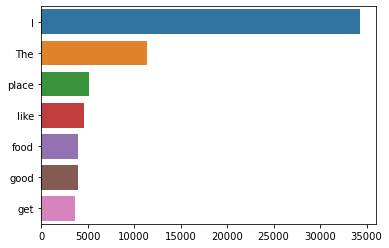

In [12]:
# most frequent non-stopwords

import collections
from collections import Counter

counter = Counter(corpus)
most = counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [13]:
# most frequent n-grams

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

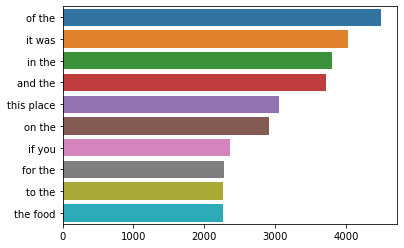

In [14]:
# bigrams
top_tri_grams = get_top_ngram(data['text'], n=2)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y, y=x)

<AxesSubplot:>

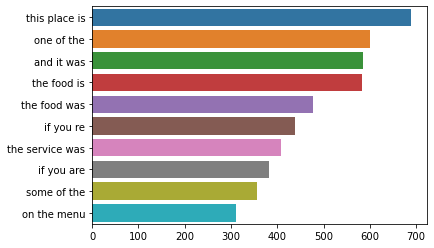

In [15]:
# trigrams
top_tri_grams = get_top_ngram(data['text'], n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y, y=x)

## Topic Modelling with pyLDAvis

In [16]:
def preprocess_text(df):
    corpus=[]
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for txt in data['text']:
        words=[w for w in word_tokenize(txt) if (w not in stop)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus = preprocess_text(txt)

In [17]:
# BOW model
dic_bow = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic_bow.doc2bow(doc) for doc in corpus]

In [18]:
# LDA model
lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic_bow,                                    
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()


[(0,
  '0.015*"n\'t" + 0.011*"place" + 0.010*"The" + 0.009*"..." + 0.009*"time" + 0.008*"like" + 0.008*"food" + 0.008*"good" + 0.008*"get" + 0.006*"one"'),
 (1,
  '0.008*"n\'t" + 0.007*"store" + 0.007*"The" + 0.005*"dog" + 0.005*"They" + 0.005*"get" + 0.004*"one" + 0.004*"like" + 0.004*"time" + 0.004*"would"'),
 (2,
  '0.019*"The" + 0.014*"place" + 0.011*"n\'t" + 0.008*"food" + 0.008*"good" + 0.007*"great" + 0.007*"time" + 0.007*"like" + 0.006*"one" + 0.005*"bar"'),
 (3,
  '0.020*"The" + 0.012*"good" + 0.011*"n\'t" + 0.010*"food" + 0.009*"place" + 0.007*"like" + 0.006*"great" + 0.006*"..." + 0.005*"really" + 0.005*"time"')]

In [ ]:
# interacting with LDA output

#!pip install pyldavis

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(lda_model, bow_corpus, dic_bow)
vis

## Wordcloud

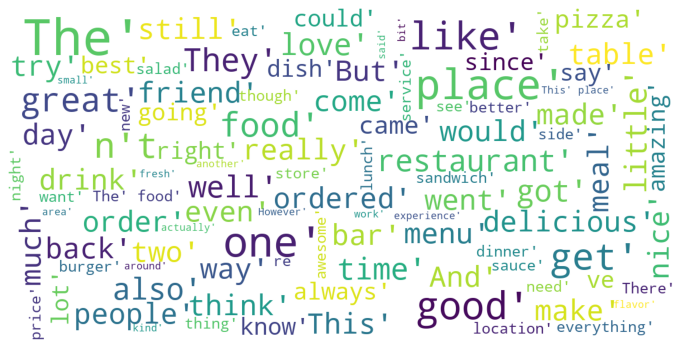

In [19]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=42)
   
    wordcloud = wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

## Sentiment

<AxesSubplot:>

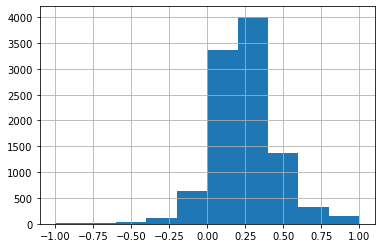

In [20]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

data['polarity_score']= data['text'].apply(lambda x : polarity(x))
data['polarity_score'].hist()

Text(0.5, 1.0, 'Polarity of Reviews')

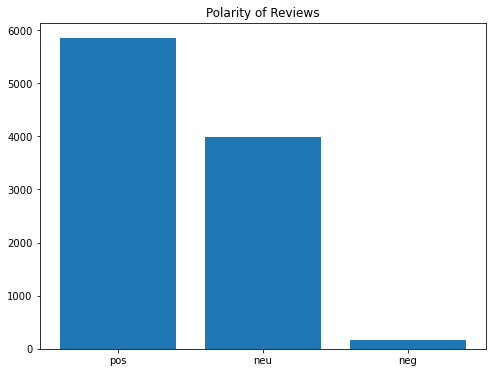

In [29]:
def sentiment(x):
    if x< -0.2:
        return 'neg'
    elif x>=-0.2 and x<=0.2:
        return 'neu'
    else:
        return 'pos'
    
data['polarity'] = data['polarity_score'].map(lambda x: sentiment(x))

plt.figure(figsize=(8,6))
plt.bar(data.polarity.value_counts().index,
        data.polarity.value_counts()) 
plt.title("Polarity of Reviews")

In [32]:
data.head(5)
# data.to_csv("data/yelpSentiment.csv")

# NER

In [ ]:
# !python -m spacy download en_core_web_sm

In [ ]:
nlp = spacy.load("en_core_web_sm")

def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

ent = data['text'].apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

In [ ]:
# entity frequencies visualization
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

In [ ]:
# we can then visualize token per entity

def ner(text,ent="ORG"):
    doc = nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

org = data['text'].apply(lambda x: ner(x))
org = [i for x in org for i in x]
counter = Counter(org)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y, x)

## POS Exploration

In [ ]:
def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

tags = data['text'].apply(lambda x : pos(x))
tags=[x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

- Noun (NN)
- Verb (VB)
- Adjective (JJ)
- Adverb(RB)
- Preposition (IN)
- Conjunction (CC)
- Pronoun(PRP)
- Interjection (INT)

In [ ]:
# drilling down even further: looking at NN
def get_adjs(text):
    adj=[]
    pos = nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag=='NN':
            adj.append(word)
    return adj


words = data['text'].apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y, y=x)

### Embeddings with BERT (Hugging Face's transformer architecture)

In [ ]:
# be sure to download the pretrained transformer via the spaCy pipeline
# !spacy download en_core_web_trf

In [ ]:
# !pip install spacy-transformers
#! python -m spacy download en_trf_bertbaseuncased_lg --quiet

In [ ]:
import en_trf_bertbaseuncased_lg

In [ ]:
#Load the bert model
nlp = en_trf_bertbaseuncased_lg.load()#spacy.load("en_core_web_trf", disable=["tagger", "attribute_ruler", "lemmatizer"])

# get sentence embeddings from input text
def get_embeddings(text):
    return nlp(text).vector

In [ ]:
# Generating sentence embedding from the text
# data['embeddings'] = data['text'].apply(get_embeddings)

df = data['text'][:50].apply(get_embeddings)
df.head()

### Transformer outputs sequences longer than the maximum length for the model (537 > 512). We will truncate the output.

In [ ]:
# it takes time to run BERT so its better to save the updated data for future use
# data.to_csv("data/yelp_embeddings.csv")

In [ ]:
# df = pd.read_csv("data/yelp_embeddings.csv")

## Base Clustering Algorithm

In [ ]:
## Import libraries
def clustering_question(data, NUM_CLUSTERS = 15):

    sentences = data['text']

    X = np.array(data['emb'].tolist())

    kclusterer = KMeansClusterer(
        NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance,
        repeats=25,avoid_empty_clusters=True)

    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

    data['cluster'] = pd.Series(assigned_clusters, index=data.index)
    data['centroid'] = data['cluster'].apply(lambda x: kclusterer.means()[x])

    return data, assigned_clusters

In [ ]:
def distance_from_centroid(row):
    # type of emb and centroid is different, hence using tolist below
    return distance_matrix([row['emb']], [row['centroid'].tolist()])[0][0]

# Compute centroid distance to the data
data['distance_from_centroid'] = data.apply(distance_from_centroid, axis=1)